In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_selection import SelectKBest, chi2
from matplotlib import pyplot as plt

# Preprocessing

In [5]:
filepath = os.path.join('data', 'breast-cancer-wisconsin.data')
df = pd.read_csv(filepath)
df.head()

,id,clump_thickness,cell_size_uniformity,cell_shape_uniformity,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [6]:
print('Benign cases: ' + str(len(df[df['class']==2])))
print('Malignant cases: ' + str(len(df[df['class']==4])))

Benign cases: 458
Malignant cases: 241


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           699 non-null    int64 
 1   clump_thickness              699 non-null    int64 
 2   cell_size_uniformity         699 non-null    int64 
 3   cell_shape_uniformity        699 non-null    int64 
 4   marginal_adhesion            699 non-null    int64 
 5   single_epithelial_cell_size  699 non-null    int64 
 6   bare_nuclei                  699 non-null    object
 7   bland_chromatin              699 non-null    int64 
 8   normal_nucleoli              699 non-null    int64 
 9   mitoses                      699 non-null    int64 
 10  class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [8]:
df['bare_nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

#### Dropping the records with missing data

In [9]:
df = df[df['bare_nuclei'] != "?"]
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

##### Dividing the DataFrame into features and classes, dropping the unnecessary 'id' column

In [10]:
X = df.drop(['id', 'class'], axis=1)
y = df['class']

# Feature selection

In [11]:
def plot_features(ranked_features):
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(ranked_features)), [value for _, value in ranked_features.items()], align='center')
    plt.yticks(range(len(ranked_features)), [key for key in ranked_features])
    plt.xlabel('Numeric ranking')
    plt.ylabel('Feature names')
    plt.tight_layout()
    plt.savefig(fname='feature_ranking.png', facecolor='white', transparent=False)
    plt.show()
    plt.close()

In [12]:
def rank_and_select(X, y, num_of_features, func):
    sel = SelectKBest(score_func=func, k=num_of_features)
    sel.fit(X, y)
    print('X shape after applying feature selection: ', sel.transform(X).shape)
    ranked_features = {feature: round(value, 3) for feature, value in zip(X.columns, sel.scores_)}
    ranked_features = dict(sorted(ranked_features.items(), key=lambda a: a[1], reverse=True))
    print('Features ranking: ')
    for i, item in enumerate(ranked_features.items()):
        print(str(i) + '.', item)
    plot_features(ranked_features)
    return ranked_features

X shape after applying feature selection:  (683, 9)
Features ranking: 
0. ('bare_nuclei', 1729.066)
1. ('cell_size_uniformity', 1370.065)
2. ('cell_shape_uniformity', 1279.768)
3. ('normal_nucleoli', 1143.867)
4. ('marginal_adhesion', 986.418)
5. ('bland_chromatin', 682.978)
6. ('clump_thickness', 624.136)
7. ('single_epithelial_cell_size', 497.537)
8. ('mitoses', 228.994)


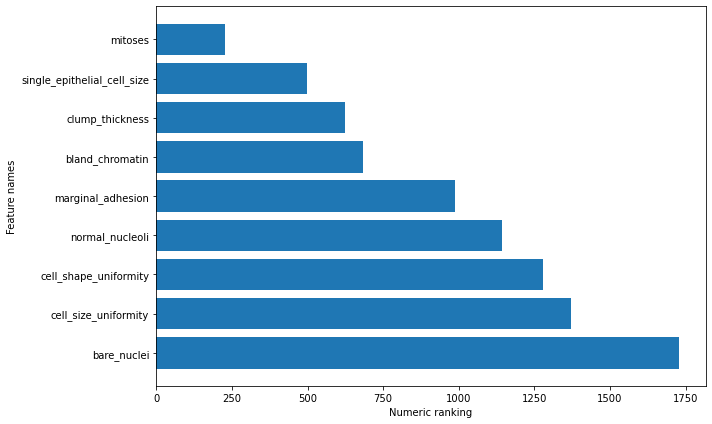

In [13]:
ranked_features = rank_and_select(X, y, X.shape[1], chi2)

# Model training and classification

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone

### Classifiers dictionary

In [15]:
clfs = {
    'gini_depth_1': DecisionTreeClassifier(criterion='gini', max_depth=1),
    'gini_depth_2': DecisionTreeClassifier(criterion='gini', max_depth=2),
    'gini_depth_4': DecisionTreeClassifier(criterion='gini', max_depth=4),
    'entropy_depth_1': DecisionTreeClassifier(criterion='entropy', max_depth=1),
    'entropy_depth_2': DecisionTreeClassifier(criterion='entropy', max_depth=2),
    'entropy_depth_4': DecisionTreeClassifier(criterion='entropy', max_depth=4)
}

### Experiment parameters 

In [16]:
n_features = len(X.columns)
n_folds = 2
n_repeats = 5
rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=1488)
results = np.zeros((len(clfs), n_features, n_folds * n_repeats))
score_func = chi2
trained_clfs = []

### Experiment loop

In [17]:
for features_index in range(0, n_features):
    trained_clfs.append([])
    for fold, (train, test) in enumerate(rskf.split(X, y)):
        trained_clfs[features_index].append([])
        sel = SelectKBest(score_func=score_func, k=features_index+1)
        sel_X = sel.fit_transform(X, y)
        for clf_idx, clf_name in enumerate(clfs):
            # Build model
            clf = clone(clfs[clf_name])
            clf.fit(sel_X[train], y[train])
            trained_clfs[features_index][fold].append(clf)

            #Test model
            y_pred = clf.predict(sel_X[test])

            #Acquire metric
            results[clf_idx, features_index, fold] = accuracy_score(y[test], y_pred)

### Experiment results 

In [18]:
means = np.mean(results, axis=2)
best_result = np.max(means)
best_classif = list(clfs.keys())[np.argmax(np.max(means, axis=1))]
best_feature_set_size = np.argmax(np.max(means, axis=0)) + 1
best_feature_set = [key for i, key in enumerate(ranked_features) if i<best_feature_set_size]

In [19]:
from contextlib import redirect_stdout

with open('experiment_results.log', 'w') as logfile:
    with redirect_stdout(logfile):
            print('CART classification tree classifier:', file=logfile)
            for clf_id, clf_name in enumerate(clfs):
                print('\tSplit quality measure: ' + clf_name.split('_')[0] + 
                    ', max tree depth: ' + clf_name.split('_')[2])
                for feature_index in range(0, n_features):
                    print('\t\tIncluded features (' + str(feature_index+1) + ') : ' +
                          str([key for i, key in enumerate(ranked_features) if i<feature_index+1]).strip('[]'))
                    print('\t\t\tMean score: ' + str(means[clf_id, feature_index]))
            
            print('\n')
            print('\tBest result: ' + str(best_result) + 
                  ' for ' + str(best_classif) + ' classifier' + 
                  ' with ' + str(best_feature_set_size) + ' features (' + str(best_feature_set).strip('[]') + ').')

#### Plots

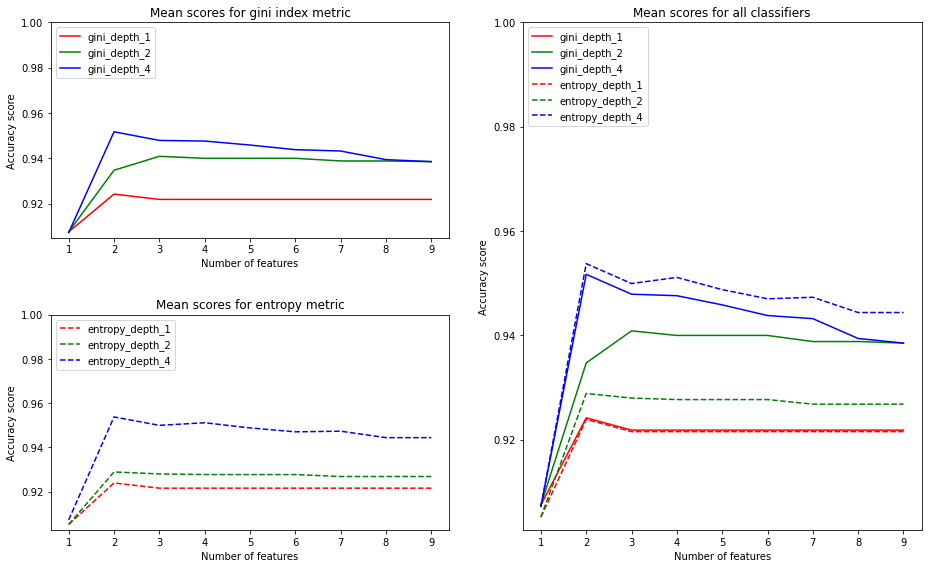

In [53]:
import matplotlib.patches as mpatches

fig, subs = plt.subplots(2,2, figsize=(13,8))
gs = subs[0,1].get_gridspec()
for sub in subs[0:,-1]:
    sub.remove()
subbig = fig.add_subplot(gs[0:,-1])

subbig.set_title('Mean scores for all classifiers')
subbig.set(xlabel='Number of features', ylabel='Accuracy score')
subs[0,0].set_title('Mean scores for gini index metric')
subs[1,0].set_title('Mean scores for entropy metric')
subs[0,0].set(xlabel='Number of features', ylabel='Accuracy score')
subs[1,0].set(xlabel='Number of features', ylabel='Accuracy score')

patch_colors = ['red', 'green', 'blue']
feature_range = [i+1 for i in range(n_features)]
legend_patches = []
gini_lines, entropy_lines, all_lines = [], [], []
gini_labels, entropy_labels, all_labels = [], [], []
for index, clf in enumerate(clfs):
    legend_patch = mpatches.Patch(color=patch_colors[index%3], label=clf)
    
    if clf.split('_')[0] == 'gini':
        line, = subs[0,0].plot(feature_range, means[index], legend_patch._original_facecolor, linestyle='-')
        gini_lines.append(line)
        gini_labels.append(clf)
        line, = subbig.plot(feature_range, means[index], legend_patch._original_facecolor, linestyle='-')
    else:
        line, = subs[1,0].plot(feature_range, means[index], legend_patch._original_facecolor, linestyle='--')
        entropy_lines.append(line)
        entropy_labels.append(clf)
        line, = subbig.plot(feature_range, means[index], legend_patch._original_facecolor, linestyle='--')
    all_lines.append(line)
    all_labels.append(clf)

subbig.legend(all_lines, all_labels, loc=2)
subs[0,0].legend(gini_lines, gini_labels, loc=2)
subs[1,0].legend(entropy_lines, entropy_labels, loc=2)

subbig.set_ylim(top=1)
subs[0,0].set_ylim(top=1)
subs[1,0].set_ylim(top=1)

fig.subplots_adjust(wspace=0.15, hspace=0.3, top=3, bottom=1, right=1.8)
fig.tight_layout(w_pad=3, h_pad=3)
fig.savefig(fname='clfs_results_comparison.png', facecolor='white', transparent=False)
plt.show()

#### Decision tree graphical representation

['bare_nuclei', 'cell_size_uniformity', 'cell_shape_uniformity', 'normal_nucleoli', 'marginal_adhesion', 'bland_chromatin', 'clump_thickness', 'single_epithelial_cell_size', 'mitoses']
|--- feature_0 <= 2.50
|   |--- class: 2
|--- feature_0 >  2.50
|   |--- class: 4

|--- feature_0 <= 2.50
|   |--- feature_1 <= 5.50
|   |   |--- class: 2
|   |--- feature_1 >  5.50
|   |   |--- class: 4
|--- feature_0 >  2.50
|   |--- feature_0 <= 4.50
|   |   |--- class: 4
|   |--- feature_0 >  4.50
|   |   |--- class: 4

|--- feature_0 <= 2.50
|   |--- feature_1 <= 5.50
|   |   |--- feature_1 <= 2.50
|   |   |   |--- class: 2
|   |   |--- feature_1 >  2.50
|   |   |   |--- feature_0 <= 1.50
|   |   |   |   |--- class: 2
|   |   |   |--- feature_0 >  1.50
|   |   |   |   |--- class: 4
|   |--- feature_1 >  5.50
|   |   |--- feature_0 <= 1.50
|   |   |   |--- class: 4
|   |   |--- feature_0 >  1.50
|   |   |   |--- class: 4
|--- feature_0 >  2.50
|   |--- feature_0 <= 4.50
|   |   |--- feature_1 <= 2.50

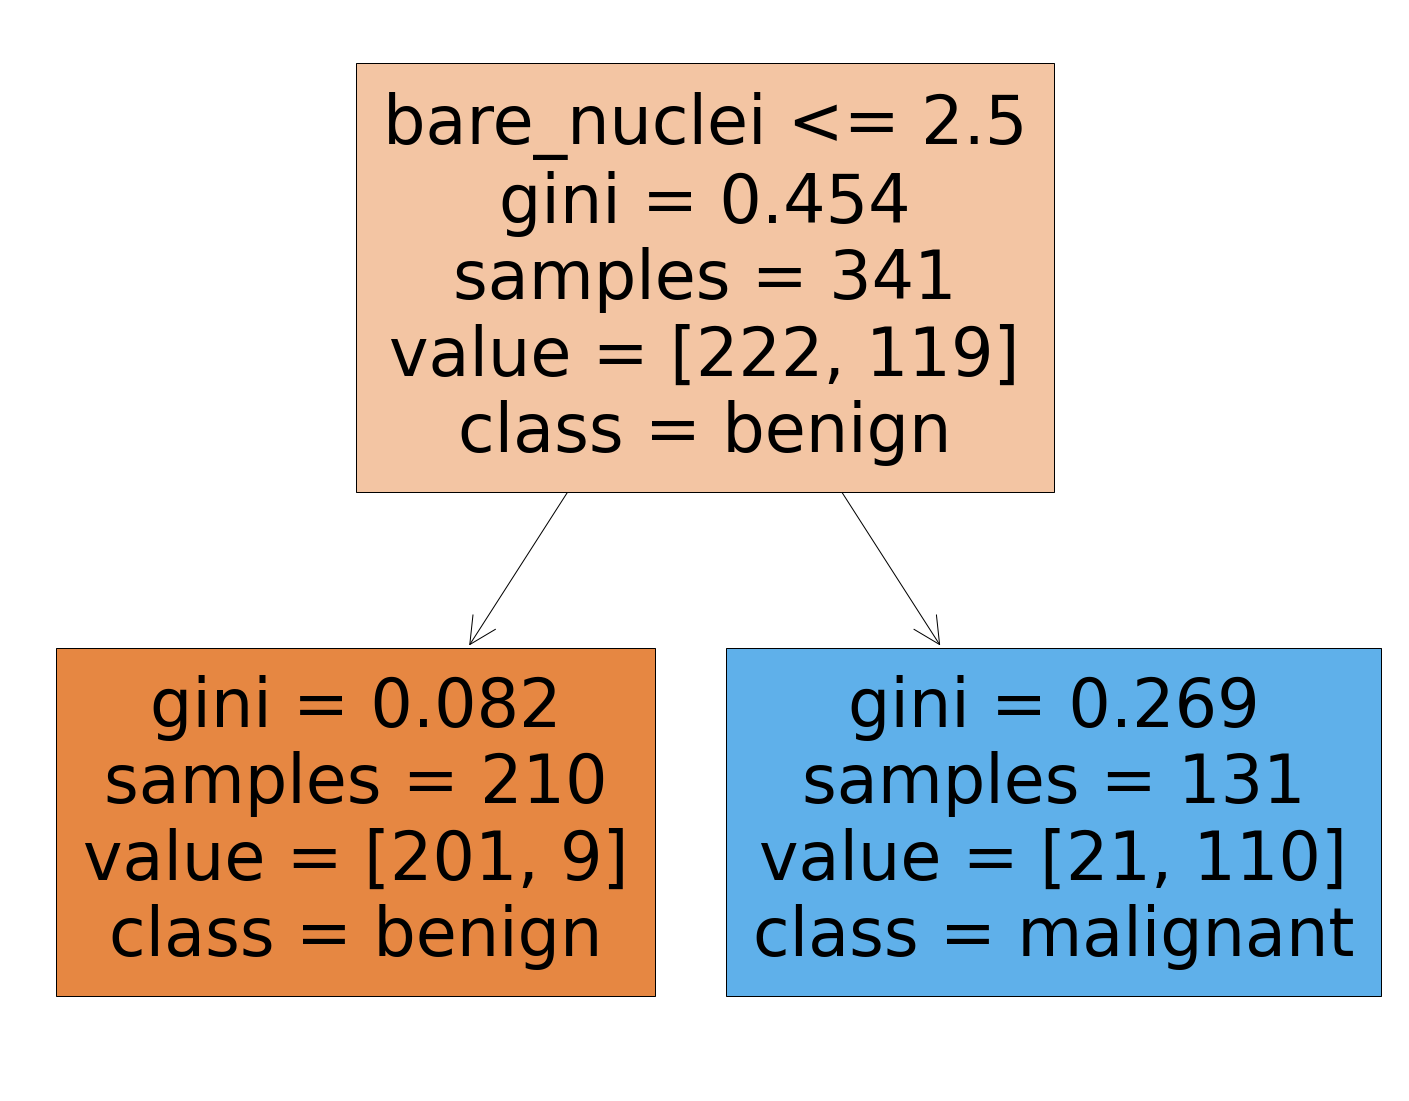

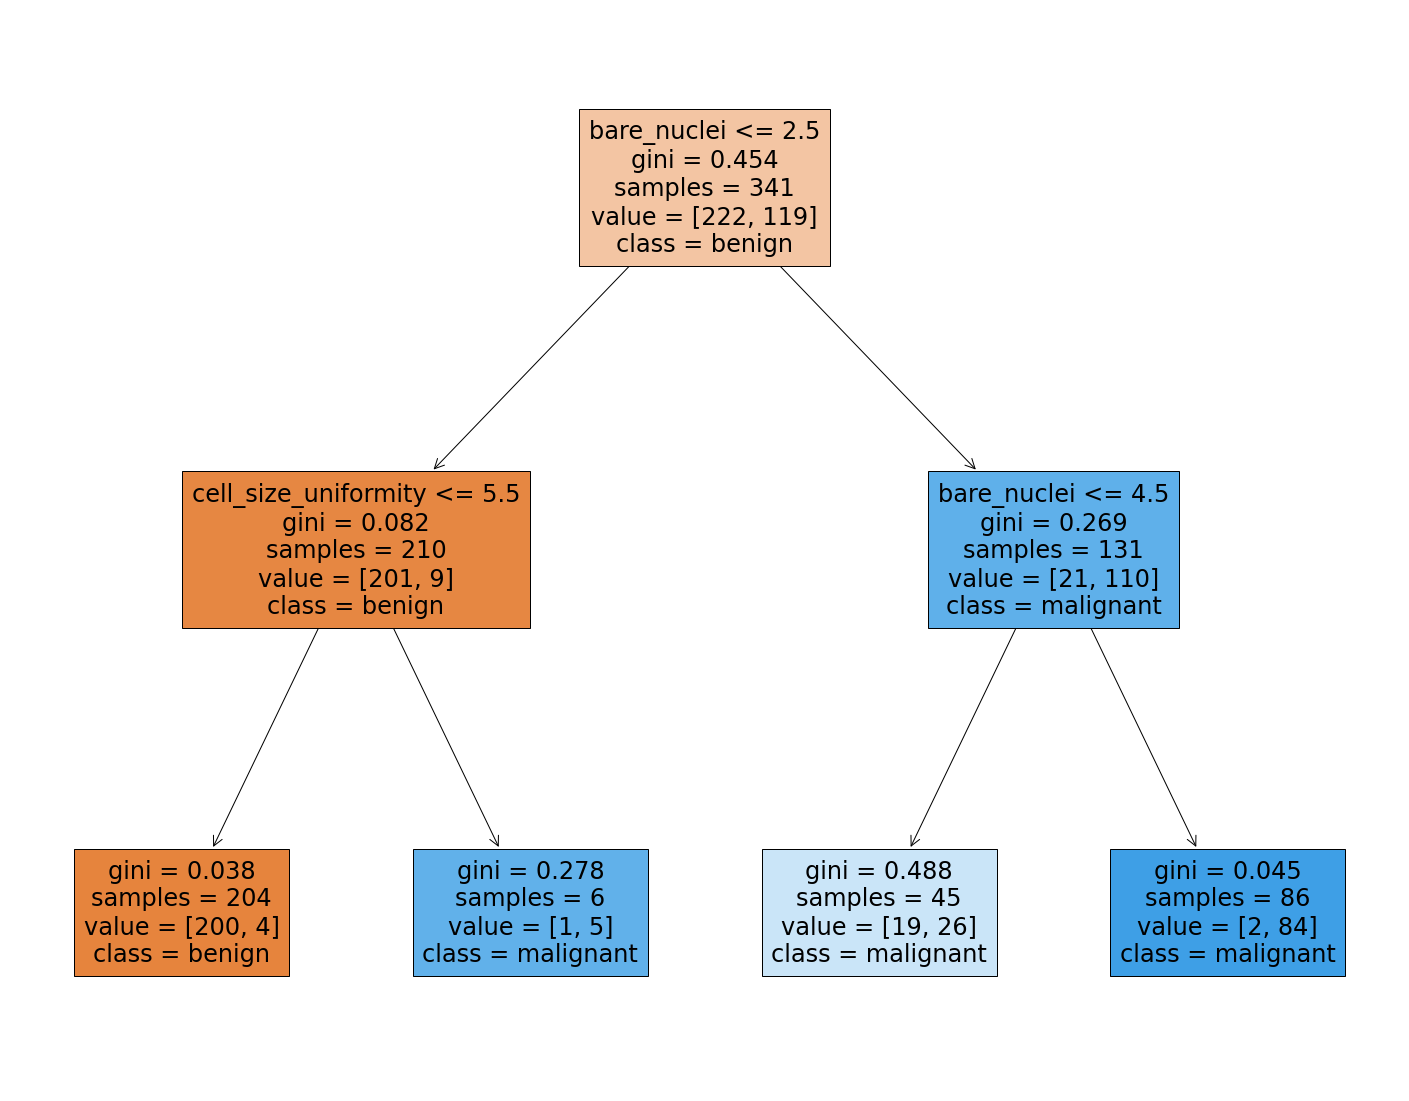

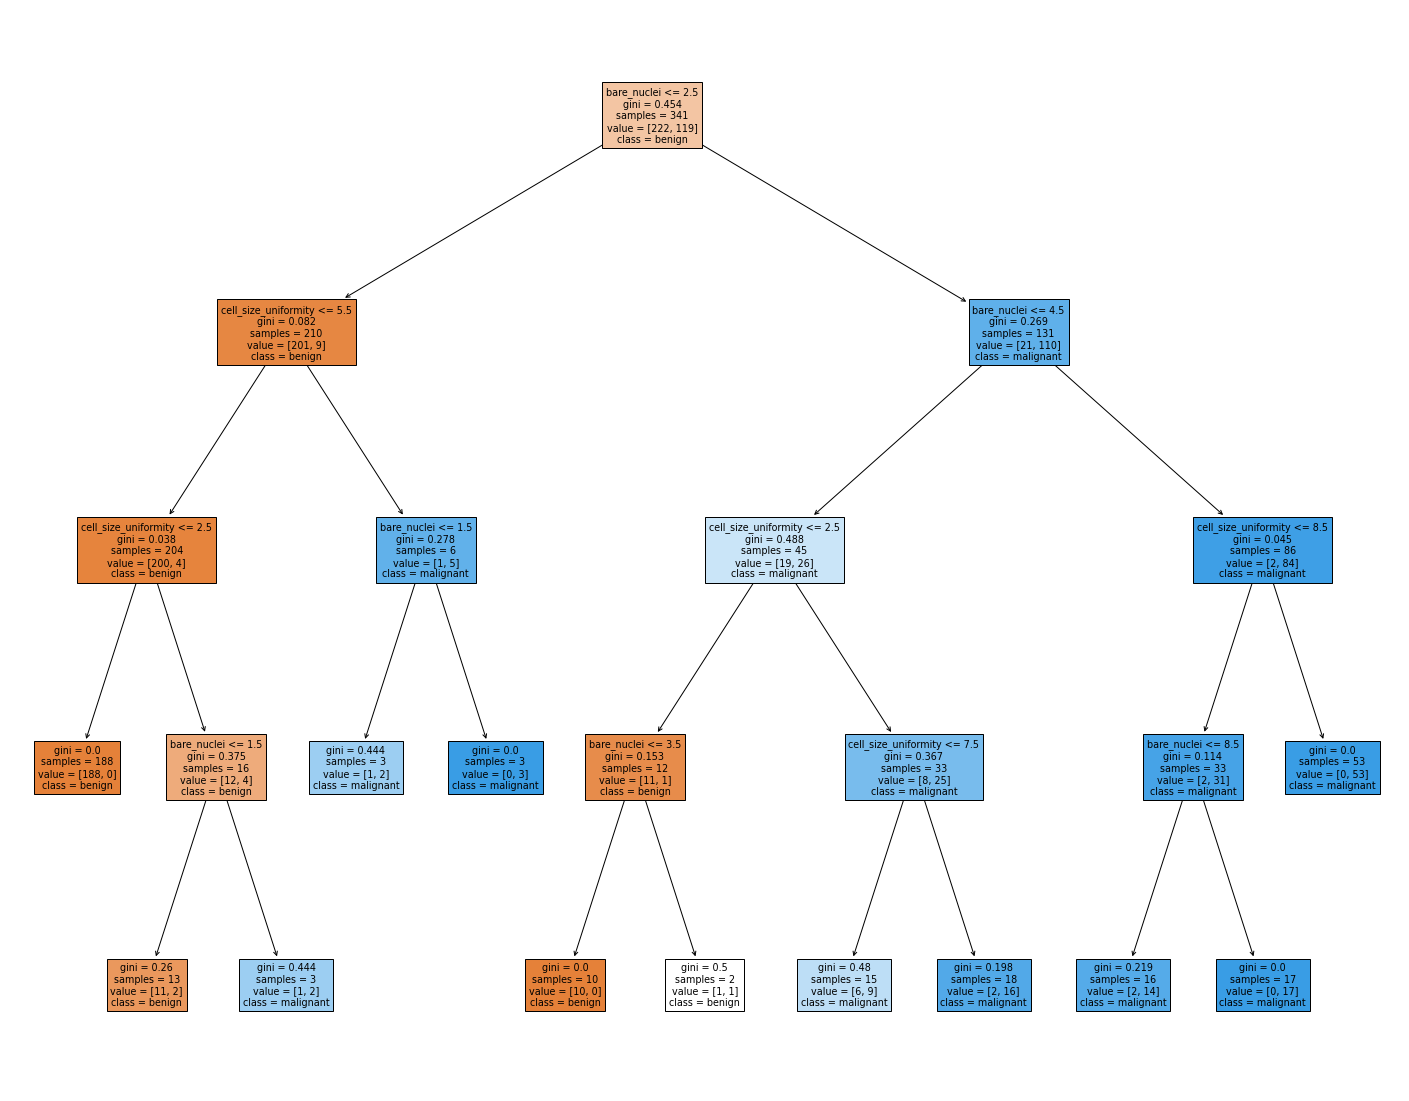

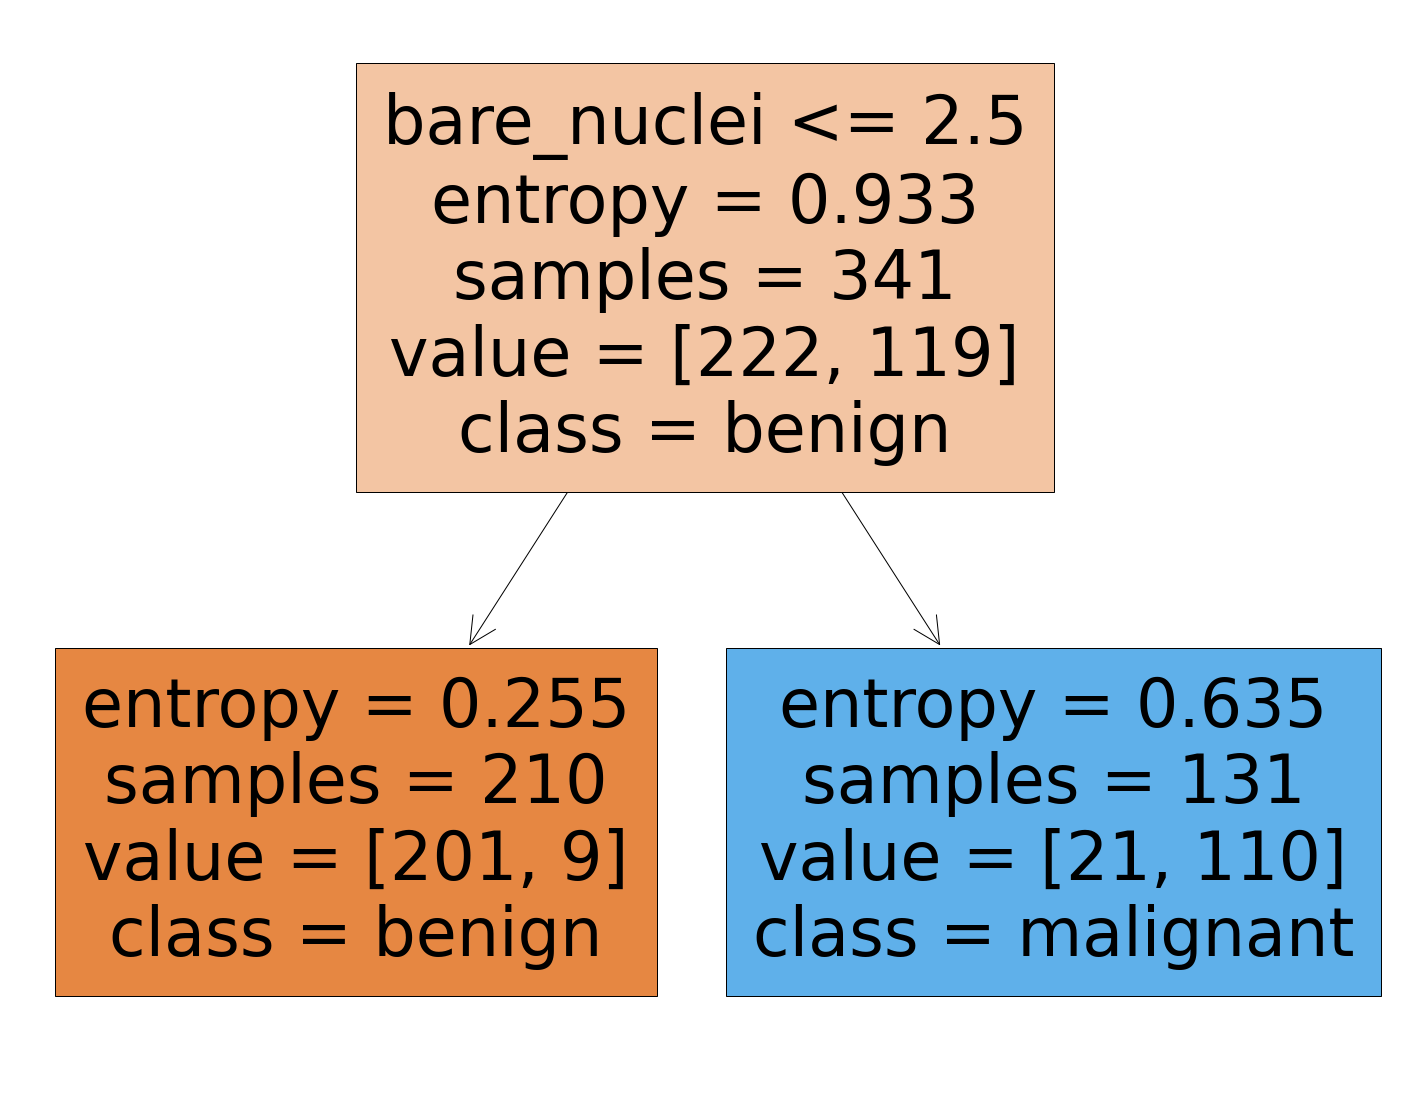

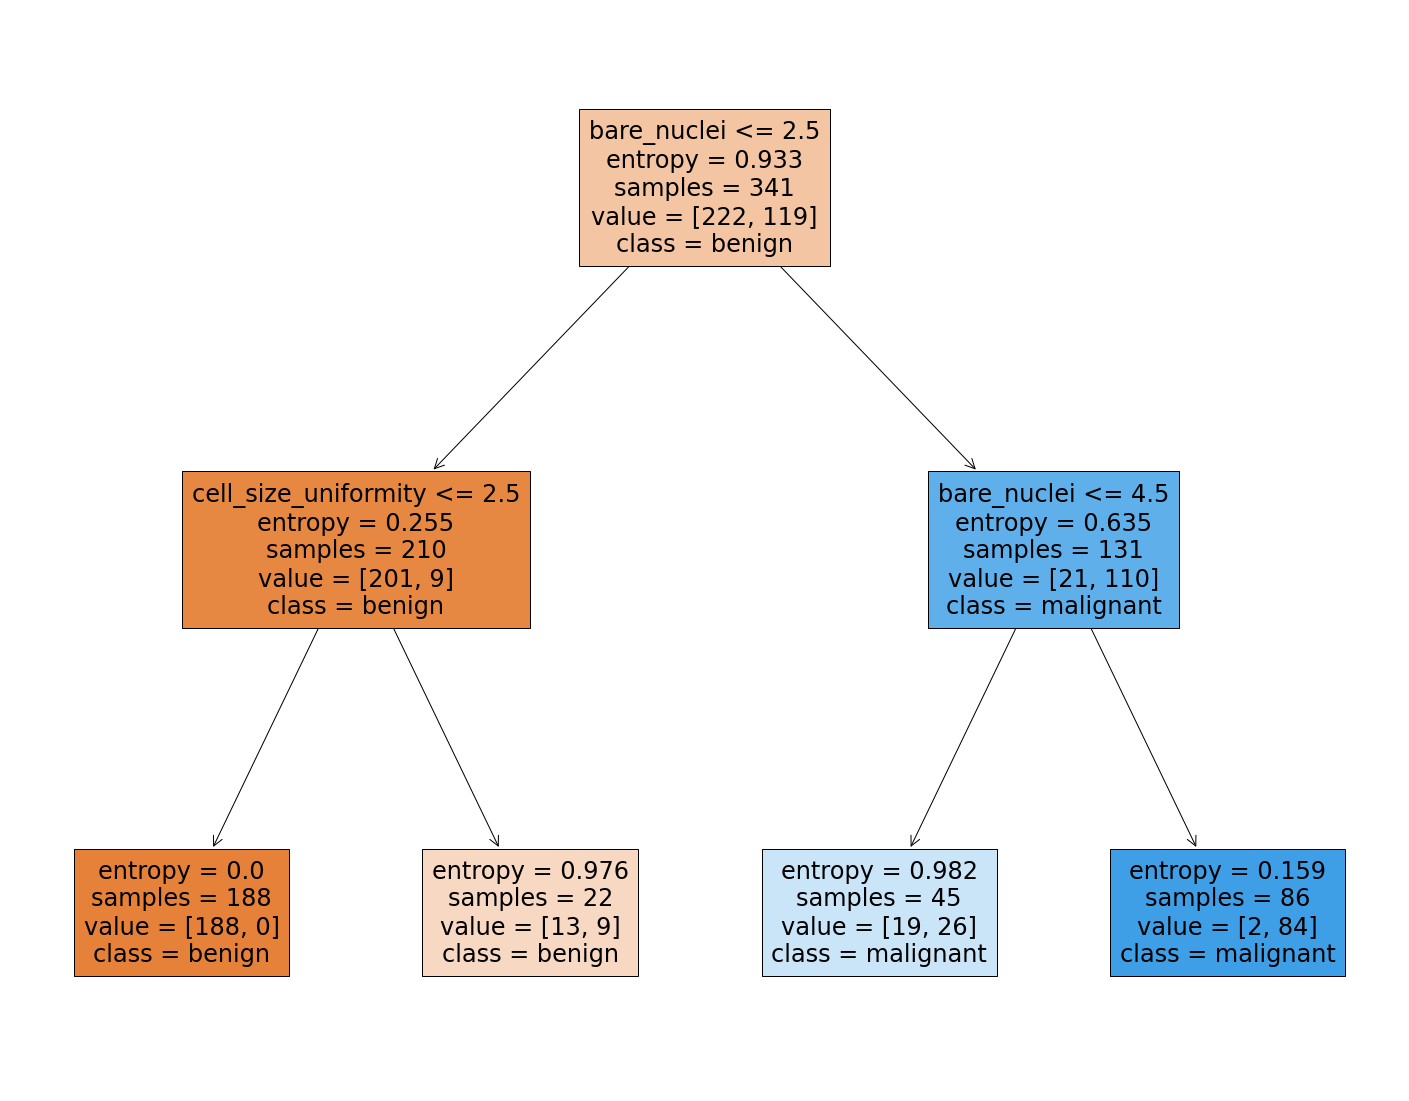

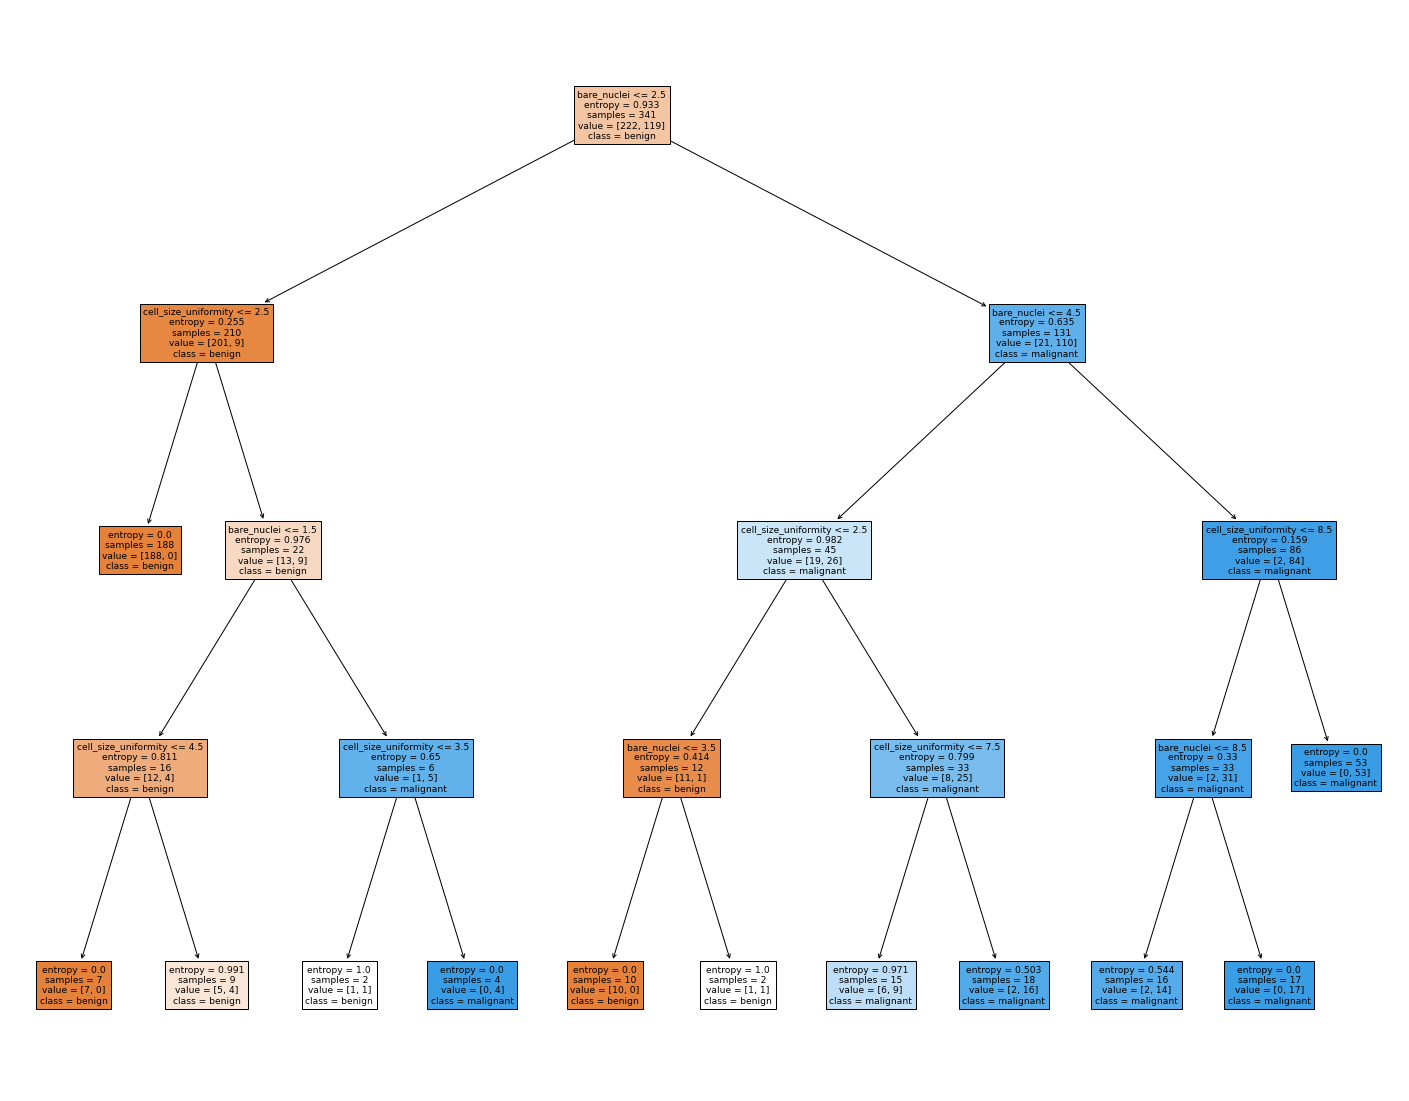

In [21]:
print(list(ranked_features.keys()))
for clf in trained_clfs[1][0]:
    text_repr = export_text(clf)
    print(text_repr)
    fig = plt.figure(figsize=(25,20))
    _ = plot_tree(clf, feature_names=list(ranked_features.keys()), class_names=['benign', 'malignant'], filled=True)

# Statistical analysis

In [22]:
from scipy.stats import ttest_ind
from tabulate import tabulate

### T-statistics and P-value

In [23]:
t_statistic_matrixes = []
p_value_matrixes = []
features_count = 9

for _ in range(features_count):
    t_statistic_matrixes.append(np.zeros((len(clfs), len(clfs))))
    p_value_matrixes.append(np.zeros((len(clfs), len(clfs))))

#our results are 6x9x10 shape (6 clfs, 9 features, 10 values)
#to statistical analysis we need to have 9 matrixes, one per feature, each with 6 sets per 10 values, one set per clf.

per_features_results = []

#separating "results" matrixes, each row as a separate array in per_features_results
for feature_index in range(features_count):
    for clf_id in range(len(clfs)):
        per_features_results.append(results[clf_id,feature_index])

#calculating statistics per feature
#added matrix_id indicating feature number
#for "feature 0" statistics are calculated for 0-5 rows
#for "feature 1" statistics are calculated for 6-11 rows.
#and so on... 
for matrix_id in range(features_count):
      for i in range(len(clfs)):
        for j in range(len(clfs)):
            t_statistic_matrixes[matrix_id][i][j], p_value_matrixes[matrix_id][i][j] = ttest_ind(per_features_results[i + matrix_id * len(clfs)], per_features_results[j + matrix_id * len(clfs)])

#presenting results
t_statistic_table = []
p_value_table = []

headers = [ clf_name for clf_name in clfs.keys()]
names_column = np.array([ [header] for header in headers ])

for i, item in enumerate(ranked_features):
    t_statistic_table = np.concatenate((names_column, t_statistic_matrixes[i]), axis=1)
    t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
    print(f"\nT-statistic for \"{item}\":\n", t_statistic_table)
    p_value_table = np.concatenate((names_column, p_value_matrixes[i]), axis=1)
    p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
    print(f"\nP-value for \"{item}\":\n", p_value_table)


T-statistic for "bare_nuclei":
                    gini_depth_1    gini_depth_2    gini_depth_4    entropy_depth_1    entropy_depth_2    entropy_depth_4
---------------  --------------  --------------  --------------  -----------------  -----------------  -----------------
gini_depth_1               0.00            0.00            0.07               0.53               0.53               0.07
gini_depth_2               0.00            0.00            0.07               0.53               0.53               0.07
gini_depth_4              -0.07           -0.07            0.00               0.48               0.48               0.00
entropy_depth_1           -0.53           -0.53           -0.48               0.00               0.00              -0.48
entropy_depth_2           -0.53           -0.53           -0.48               0.00               0.00              -0.48
entropy_depth_4           -0.07           -0.07            0.00               0.48               0.48               0.00

### Advantage

In [24]:
advantages = []

for _ in range(features_count):
    advantages.append(np.zeros((len(clfs), len(clfs))))

for index,t_statistic in enumerate(t_statistic_matrixes):
    advantages[index][t_statistic > 0] = 1

for i, item in enumerate(ranked_features):
    advantage_table = np.concatenate((names_column, advantages[i]), axis=1)
    advantage_table = tabulate(advantage_table, headers, floatfmt=".2f")
    print(f"\nAdvantage for \"{item}\":\n", advantage_table)


Advantage for "bare_nuclei":
                    gini_depth_1    gini_depth_2    gini_depth_4    entropy_depth_1    entropy_depth_2    entropy_depth_4
---------------  --------------  --------------  --------------  -----------------  -----------------  -----------------
gini_depth_1               0.00            0.00            1.00               1.00               1.00               1.00
gini_depth_2               0.00            0.00            1.00               1.00               1.00               1.00
gini_depth_4               0.00            0.00            0.00               1.00               1.00               0.00
entropy_depth_1            0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_2            0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_4            0.00            0.00            0.00               1.00               1.00               0.00



### Statistical significance

In [25]:
alfa = .05
significances = []

for _ in range(features_count):
    significances.append(np.zeros((len(clfs), len(clfs))))

for index,p_value in enumerate(p_value_matrixes):
    significances[index][p_value <= alfa] = 1
    
for i, item in enumerate(ranked_features):
    significances_table = np.concatenate((names_column, significances[i]), axis=1)
    significances_table = tabulate(significances_table, headers, floatfmt=".2f")
    print(f"\nStatistical significance for \"{item}\":\n", significances_table)


Statistical significance for "bare_nuclei":
                    gini_depth_1    gini_depth_2    gini_depth_4    entropy_depth_1    entropy_depth_2    entropy_depth_4
---------------  --------------  --------------  --------------  -----------------  -----------------  -----------------
gini_depth_1               0.00            0.00            0.00               0.00               0.00               0.00
gini_depth_2               0.00            0.00            0.00               0.00               0.00               0.00
gini_depth_4               0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_1            0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_2            0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_4            0.00            0.00            0.00               0.00               0.00      

### Statistically significantly better - final results

In [26]:
stat_better_matrixes = []

for i in range(features_count):
    stat_better = significances[i] * advantages[i]
    stat_better_matrixes.append(stat_better)

for i, item in enumerate(ranked_features):
    final_table = np.concatenate((names_column, stat_better_matrixes[i]), axis=1)
    final_table = tabulate(final_table, headers, floatfmt=".2f")
    print(f"\nStatistically significantly better for \"{item}\":\n", final_table)


Statistically significantly better for "bare_nuclei":
                    gini_depth_1    gini_depth_2    gini_depth_4    entropy_depth_1    entropy_depth_2    entropy_depth_4
---------------  --------------  --------------  --------------  -----------------  -----------------  -----------------
gini_depth_1               0.00            0.00            0.00               0.00               0.00               0.00
gini_depth_2               0.00            0.00            0.00               0.00               0.00               0.00
gini_depth_4               0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_1            0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_2            0.00            0.00            0.00               0.00               0.00               0.00
entropy_depth_4            0.00            0.00            0.00               0.00               